In [1123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pprint import pprint
import math
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from tqdm import tqdm

#from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('stopwords')
pd.options.mode.chained_assignment = None  # default='warn'
#import requests
#import re

[nltk_data] Downloading package wordnet to /Users/ellen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ellen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [3]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
tmdb_movies = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")
movies

Movie_ID  Year                                               Name
0             1  2003                                    Dinosaur Planet
1             2  2004                         Isle of Man TT 2004 Review
2             3  1997                                          Character
3             4  1994                       Paula Abdul's Get Up & Dance
4             5  2004                           The Rise and Fall of ECW
...         ...   ...                                                ...
17765     17766  2002  Where the Wild Things Are and Other Maurice Se...
17766     17767  2004                  Fidel Castro: American Experience
17767     17768  2000                                              Epoch
17768     17769  2003                                        The Company
17769     17770  2003                                       Alien Hunter

[17770 rows x 3 columns]

In [4]:
ratings

User_ID  Rating  Movie_ID
0          712664       5         3
1         1331154       4         3
2         2632461       3         3
3           44937       5         3
4          656399       4         3
...           ...     ...       ...
17337453   520675       3      4496
17337454  1055714       5      4496
17337455  2643029       4      4496
17337456  1559566       3      4496
17337457   293198       3      4496

[17337458 rows x 3 columns]

In [5]:
credits

movie_id                                     title  \
0        19995                                    Avatar   
1          285  Pirates of the Caribbean: At World's End   
2       206647                                   Spectre   
3        49026                     The Dark Knight Rises   
4        49529                               John Carter   
...        ...                                       ...   
4798      9367                               El Mariachi   
4799     72766                                 Newlyweds   
4800    231617                 Signed, Sealed, Delivered   
4801    126186                          Shanghai Calling   
4802     25975                         My Date with Drew   

                                                   cast  \
0     [{"cast_id": 242, "character": "Jake Sully", "...   
1     [{"cast_id": 4, "character": "Captain Jack Spa...   
2     [{"cast_id": 1, "character": "James Bond", "cr...   
3     [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4     [{"cast_id": 5, "character": "John Carter", "c...   
...                                                 ...   
4798  [{"cast_id": 1, "character": "El Mariachi", "c...   
4799  [{"cast_id": 1, "character": "Buzzy", "credit_...   
4800  [{"cast_id": 8, "character": "Oliver O\u2019To...   
4801  [{"cast_id": 3, "character": "Sam", "credit_id...   
4802  [{"cast_id": 3, "character": "Herself", "credi...   

                                                   crew  
0     [{"credit_id": "52fe48009251416c750aca23", "de...  
1     [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2     [{"credit_id": "54805967c3a36829b5002c41", "de...  
3     [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4     [{"credit_id": "52fe479ac3a36847f813eaa3", "de...  
...                                                 ...  
4798  [{"credit_id": "52fe44eec3a36847f80b280b", "de...  
4799  [{"credit_id": "52fe487dc3a368484e0fb013", "de...  
4800  [{"credit_id": "52fe4df3c3a36847f8275ecf", "de...  
4801  [{"credit_id": "52fe4ad9c3a368484e16a36b", "de...  
4802  [{"credit_id": "58ce021b9251415a390165d9", "de...  

[4803 rows x 4 columns]

In [120]:
credits.iloc[1]['cast']

'[{"cast_id": 4, "character": "Captain Jack Sparrow", "credit_id": "52fe4232c3a36847f800b50d", "gender": 2, "id": 85, "name": "Johnny Depp", "order": 0}, {"cast_id": 5, "character": "Will Turner", "credit_id": "52fe4232c3a36847f800b511", "gender": 2, "id": 114, "name": "Orlando Bloom", "order": 1}, {"cast_id": 6, "character": "Elizabeth Swann", "credit_id": "52fe4232c3a36847f800b515", "gender": 1, "id": 116, "name": "Keira Knightley", "order": 2}, {"cast_id": 12, "character": "William \\"Bootstrap Bill\\" Turner", "credit_id": "52fe4232c3a36847f800b52d", "gender": 2, "id": 1640, "name": "Stellan Skarsg\\u00e5rd", "order": 3}, {"cast_id": 10, "character": "Captain Sao Feng", "credit_id": "52fe4232c3a36847f800b525", "gender": 2, "id": 1619, "name": "Chow Yun-fat", "order": 4}, {"cast_id": 9, "character": "Captain Davy Jones", "credit_id": "52fe4232c3a36847f800b521", "gender": 2, "id": 2440, "name": "Bill Nighy", "order": 5}, {"cast_id": 7, "character": "Captain Hector Barbossa", "credit_

In [6]:
tmdb_movies

budget                                             genres  \
0     237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1     300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2     245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3     250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4     260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
...         ...                                                ...   
4798     220000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4799       9000  [{"id": 35, "name": "Comedy"}, {"id": 10749, "...   
4800          0  [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...   
4801          0                                                 []   
4802          0                [{"id": 99, "name": "Documentary"}]   

                                               homepage      id  \
0                           http://www.avatarmovie.com/   19995   
1          http://disney.go.com/disneypictures/pirates/     285   
2           http://www.sonypictures.com/movies/spectre/  206647   
3                    http://www.thedarkknightrises.com/   49026   
4                  http://movies.disney.com/john-carter   49529   
...                                                 ...     ...   
4798                                                NaN    9367   
4799                                                NaN   72766   
4800  http://www.hallmarkchannel.com/signedsealeddel...  231617   
4801                        http://shanghaicalling.com/  126186   
4802                                                NaN   25975   

                                               keywords original_language  \
0     [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1     [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2     [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   
3     [{"id": 849, "name": "dc comics"}, {"id": 853,...                en   
4     [{"id": 818, "name": "based on novel"}, {"id":...                en   
...                                                 ...               ...   
4798  [{"id": 5616, "name": "united states\u2013mexi...                es   
4799                                                 []                en   
4800  [{"id": 248, "name": "date"}, {"id": 699, "nam...                en   
4801                                                 []                en   
4802  [{"id": 1523, "name": "obsession"}, {"id": 224...                en   

                                original_title  \
0                                       Avatar   
1     Pirates of the Caribbean: At World's End   
2                                      Spectre   
3                        The Dark Knight Rises   
4                                  John Carter   
...                                        ...   
4798                               El Mariachi   
4799                                 Newlyweds   
4800                 Signed, Sealed, Delivered   
4801                          Shanghai Calling   
4802                         My Date with Drew   

                                               overview  popularity  \
0     In the 22nd century, a paraplegic Marine is di...  150.437577   
1     Captain Barbossa, long believed to be dead, ha...  139.082615   
2     A cryptic message from Bond’s past sends him o...  107.376788   
3     Following the death of District Attorney Harve...  112.312950   
4     John Carter is a war-weary, former military ca...   43.926995   
...                                                 ...         ...   
4798  El Mariachi just wants to play his guitar and ...   14.269792   
4799  A newlywed couple's honeymoon is upended by th...    0.642552   
4800  "Signed, Sealed, Delivered" introduces a dedic...    1.444476   
4801  When ambitious New York attorney Sam is sent t...    0.857008   
4802  Ever since the second grade when he first saw ... 

In [7]:
df_movies = movies[movies.Name.isin(credits.title)]
df_movies

Movie_ID  Year                    Name
2             3  1997               Character
23           24  1981     My Bloody Valentine
29           30  2003  Something's Gotta Give
44           45  1999         The Love Letter
54           55  1995                    Jade
...         ...   ...                     ...
17742     17743  2003    Better Luck Tomorrow
17757     17758  1979                Prophecy
17761     17762  1997                 Gattaca
17763     17764  1998     Shakespeare in Love
17768     17769  2003             The Company

[2244 rows x 3 columns]

In [67]:
df_tmdb = tmdb_movies[tmdb_movies.title.isin(df_movies.Name)].reset_index()
df_tmdb

index     budget                                             genres  \
0         6  260000000  [{"id": 16, "name": "Animation"}, {"id": 10751...   
1        16  220000000  [{"id": 878, "name": "Science Fiction"}, {"id"...   
2        21  200000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3        24  207000000  [{"id": 12, "name": "Adventure"}, {"id": 18, "...   
4        25  200000000  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
...     ...        ...                                                ...   
2055   4779          0                     [{"id": 35, "name": "Comedy"}]   
2056   4788      12000  [{"id": 27, "name": "Horror"}, {"id": 35, "nam...   
2057   4790          0  [{"id": 18, "name": "Drama"}, {"id": 10769, "n...   
2058   4792      20000  [{"id": 80, "name": "Crime"}, {"id": 27, "name...   
2059   4796       7000  [{"id": 878, "name": "Science Fiction"}, {"id"...   

                                          homepage     id  \
0     http://disney.go.com/disneypictures/tangled/  38757   
1                http://marvel.com/avengers_movie/  24428   
2                http://www.robinhoodthemovie.com/  20662   
3                                              NaN    254   
4                      http://www.titanicmovie.com    597   
...                                            ...    ...   
2055                                           NaN  14022   
2056                                           NaN    692   
2057                                           NaN  13898   
2058                                           NaN  36095   
2059                    http://www.primermovie.com  14337   

                                               keywords original_language  \
0     [{"id": 1562, "name": "hostage"}, {"id": 2343,...                en   
1     [{"id": 242, "name": "new york"}, {"id": 5539,...                en   
2     [{"id": 4147, "name": "robin hood"}, {"id": 43...                en   
3     [{"id": 774, "name": "film business"}, {"id": ...                en   
4     [{"id": 2580, "name": "shipwreck"}, {"id": 298...                en   
...                                                 ...               ...   
2055  [{"id": 305, "name": "moon"}, {"id": 490, "nam...                en   
2056  [{"id": 237, "name": "gay"}, {"id": 900, "name...                en   
2057                                                 []                fa   
2058  [{"id": 233, "name": "japan"}, {"id": 549, "na...                ja   
2059  [{"id": 1448, "name": "distrust"}, {"id": 2101...                en   

      original_title                                           overview  \
0            Tangled  When the kingdom's most wanted-and most charmi...   
1       The Avengers  When an unexpected enemy emerges and threatens...   
2         Robin Hood  When soldier Robin happens upon the dying Robe...   
3          King Kong  In 1933 New York, an overly ambitious movie pr...   
4            Titanic  84 years later, a 101-year-old woman named Ros...   
...              ...                                                ...   
2055         Slacker  Presents a day in the life in Austin, Texas am...   
2056  Pink Flamingos  Notorious Baltimore criminal and underground f...   
2057           دایره  Various women struggle to function in the oppr...   
2058             キュア  A wave of gruesome murders is sweeping Tokyo. ...   
2059          Primer  Friends/fledgling entrepreneurs invent a devic...   

      popularity  ...                               production_countries  \
0      48.681969  ...  [{"iso_3166_1": "US", "name": "United States o...   
1     144.448633  ...  [{"iso_3166_1": "US", "name": "United States o...   
2      37.668301  ...  [{"iso_3166_1": "GB", "name": "United Kingdom"...   
3      61.226010  ...  [{"iso_3166_1": "NZ", "name": "New Zealand"}, ...   
4     100.025899  ...  [{"iso_3166_1": "US", "name": "United States o...   
...          ...  ...                                             

In [68]:
movie_text = df_tmdb[['genres', 'keywords', 'overview', 'tagline']]

In [69]:
movie_text['genre_text'] = movie_text['genres'].apply(json.loads)
movie_text['keywords_text'] = movie_text['keywords'].apply(json.loads)

In [70]:
genre_dict = {}
keyword_dict = {}
for i in range(0,len(movie_text)): #loop through index
    genre_list = []
    keyword_list = []
    for j in range(0, len(movie_text['genre_text'][i])): #loop through genres for that row
        genre_list.append(movie_text['genre_text'][i][j]['name'])
    genre_dict[i] = ', '.join(genre_list)
    
    for k in range(0, len(movie_text['keywords_text'][i])): #loop through keywords
        keyword_list.append(movie_text['keywords_text'][i][k]['name'])
    keyword_dict[i] = ', '.join(keyword_list)
    
#we need to do the same with keywords as we did with genre to get genre_text


In [91]:
movie_text['genre_text'] = genre_dict.values()
movie_text['keywords_text'] = keyword_dict.values()

In [92]:
movie_text

overview  \
0     kingdom wanted-and charming-bandit flynn rider...   
1     unexpected enemy emerges threatens global safe...   
2     soldier robin happens upon dying robert loxley...   
3     1933 new york overly ambitious movie producer ...   
4     84 year later 101-year-old woman named rose de...   
...                                                 ...   
2055  present day life austin texas among social out...   
2056  notorious baltimore criminal underground figur...   
2057  various woman struggle function oppressively s...   
2058  wave gruesome murder sweeping tokyo connection...   
2059  friends/fledgling entrepreneur invent device g...   

                                 tagline                          genre_text  \
0     theyre taking adventure new length                   Animation, Family   
1                      assembly required  Science Fiction, Action, Adventure   
2       rise rise again lamb become lion                   Action, Adventure   
3                    eighth wonder world            Adventure, Drama, Action   
4          nothing earth could come them            Drama, Romance, Thriller   
...                                  ...                                 ...   
2055                                                                  Comedy   
2056                 exercise poor taste               Horror, Comedy, Crime   
2057                                                          Drama, Foreign   
2058               madness terror murder    Crime, Horror, Mystery, Thriller   
2059               happens actually work    Science Fiction, Drama, Thriller   

                                          keywords_text  
0     hostage, magic, horse, fairy tale, musical, pr...  
1     new york, shield, marvel comic, superhero, bas...  
2     robin hood, archer, knight, sherwood forest, b...  
3     film business, screenplay, show business, film...  
4     shipwreck, iceberg, ship, panic, titanic, ocea...  
...                                                 ...  
2055  moon, philosophy, burglar, texas, dream, atomi...  
2056  gay, trailer park, pop culture, drug dealer, h...  
2057                                                     
2058  japan, prostitute, hotel, based on novel, hall...  
2059  distrust, garage, identity crisis, time travel...  

[2060 rows x 4 columns]

In [93]:
movie_text = movie_text[['overview', 'tagline', 'genre_text', 'keywords_text']] #choose columns
movie_text = movie_text.fillna(' ') #substitute NaN values with empty string

movie_text

overview  \
0     kingdom wanted-and charming-bandit flynn rider...   
1     unexpected enemy emerges threatens global safe...   
2     soldier robin happens upon dying robert loxley...   
3     1933 new york overly ambitious movie producer ...   
4     84 year later 101-year-old woman named rose de...   
...                                                 ...   
2055  present day life austin texas among social out...   
2056  notorious baltimore criminal underground figur...   
2057  various woman struggle function oppressively s...   
2058  wave gruesome murder sweeping tokyo connection...   
2059  friends/fledgling entrepreneur invent device g...   

                                 tagline                          genre_text  \
0     theyre taking adventure new length                   Animation, Family   
1                      assembly required  Science Fiction, Action, Adventure   
2       rise rise again lamb become lion                   Action, Adventure   
3                    eighth wonder world            Adventure, Drama, Action   
4          nothing earth could come them            Drama, Romance, Thriller   
...                                  ...                                 ...   
2055                                                                  Comedy   
2056                 exercise poor taste               Horror, Comedy, Crime   
2057                                                          Drama, Foreign   
2058               madness terror murder    Crime, Horror, Mystery, Thriller   
2059               happens actually work    Science Fiction, Drama, Thriller   

                                          keywords_text  
0     hostage, magic, horse, fairy tale, musical, pr...  
1     new york, shield, marvel comic, superhero, bas...  
2     robin hood, archer, knight, sherwood forest, b...  
3     film business, screenplay, show business, film...  
4     shipwreck, iceberg, ship, panic, titanic, ocea...  
...                                                 ...  
2055  moon, philosophy, burglar, texas, dream, atomi...  
2056  gay, trailer park, pop culture, drug dealer, h...  
2057                                                     
2058  japan, prostitute, hotel, based on novel, hall...  
2059  distrust, garage, identity crisis, time travel...  

[2060 rows x 4 columns]

In [94]:
def remove(string, regex):
    result = re.sub(regex, '', string)
    
    return result

In [402]:
def removePunctuation(string): #remove: . , ! ? ' ’ : " ( ) $ - and numbers
    reg = [r'\.', r'\,', r'\?', r'\'', r'’', r'\"', r':', r'\(', r'\)', r'\$', r'-', r'\d'] 

    for r in reg:
        string = remove(string, r)
        
    return string

In [404]:
def removeStopWords(string):
    new_string = []
    stopWords = stopwords.words('english')
    
    for s in string.split():
        if s not in stopWords:
            new_string.append(s)
    final_string = ' '.join(new_string)
    
    return final_string

### Lemmatization
Lemmatization is used instead of stemming because the lemmatization uses lexical knowledge base to get base form of words insteaf of cutting the last part of the word. [Link to article for reference](https://medium.com/product-ai/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908)

In [405]:
def lemmatize(string):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    
    for w in string.split():
        lemmatized_words.append(lemmatizer.lemmatize(w))
    lemmatized_sentence = ' '.join(lemmatized_words)
    
    return lemmatized_sentence

In [406]:
#def tokenize(string):

In [407]:
def preProcess(df):
    for col in df.columns:
        lower = df[col].str.lower() #lowercase
        removeStopW = lower.apply(lambda x: removeStopWords(x)) #remove stop words
        removePunct = removeStopW.apply(lambda x: removePunctuation(x)) #remove punctuation
        df[(col)] = removePunct.apply(lambda x: lemmatize(x)) #lemmatize
    
    return df

In [408]:
df_preprocessed = preProcess(movie_text)
df_preprocessed

overview  \
0     kingdom wantedand charmingbandit flynn rider h...   
1     unexpected enemy emerges threatens global safe...   
2     soldier robin happens upon dying robert loxley...   
3     new york overly ambitious movie producer coerc...   
4     year later yearold woman named rose dewitt buk...   
...                                                 ...   
2055  present day life austin texas among social out...   
2056  notorious baltimore criminal underground figur...   
2057  various woman struggle function oppressively s...   
2058  wave gruesome murder sweeping tokyo connection...   
2059  friends/fledgling entrepreneur invent device g...   

                                 tagline                        genre_text  \
0     theyre taking adventure new length                  animation family   
1                      assembly required  science fiction action adventure   
2             rise rise lamb become lion                  action adventure   
3                    eighth wonder world            adventure drama action   
4               nothing earth could come            drama romance thriller   
...                                  ...                               ...   
2055                                                                comedy   
2056                 exercise poor taste               horror comedy crime   
2057                                                         drama foreign   
2058               madness terror murder     crime horror mystery thriller   
2059               happens actually work    science fiction drama thriller   

                                          keywords_text  
0     hostage magic horse fairy tale musical princes...  
1     new york shield marvel comic superhero based c...  
2     robin hood archer knight sherwood forest bow a...  
3     film business screenplay show business film ma...  
4     shipwreck iceberg ship panic titanic ocean lin...  
...                                                 ...  
2055  moon philosophy burglar texas dream atomic bom...  
2056  gay trailer park pop culture drug dealer heroi...  
2057                                                     
2058  japan prostitute hotel based novel hallucinati...  
2059  distrust garage identity crisis time travel ti...  

[2060 rows x 4 columns]

In [1260]:
overview_text = ','.join(df_preprocessed.overview).split(',')
tagline_text = ','.join(df_preprocessed.tagline).split(',')
genre_text = ','.join(df_preprocessed.genre_text).split(',')
keywords_text = ','.join(df_preprocessed.keywords_text).split(',')

#get each string into array.
overviewText = [d.split() for d in overview_text]
taglineText = [d.split() for d in tagline_text]
genreText = [d.split() for d in genre_text]
keywordsText = [d.split() for d in keywords_text]

#create dictionary
overview_dict = corpora.Dictionary(overviewText)
tagline_dict = corpora.Dictionary(taglineText)
genre_dict = corpora.Dictionary(genreText)
keywords_dict = corpora.Dictionary(keywordsText)

overviewCorpus = [id2word.doc2bow(text) for text in overviewText]
taglineCorpus = [id2word.doc2bow(text) for text in taglineText]
genreCorpus = [id2word.doc2bow(text) for text in genreText]
keywordsCorpus = [id2word.doc2bow(text) for text in keywordsText]

### TF-IDF

There are several different kinds of TF-IDF, but here is used the one taught in class. 

In [1327]:
def tf_idf(corpus, dictionary, documents):
    N = len(corpus) #number of documents
    f = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    tf = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    n_t = np.zeros(len(dictionary)) #array for counting number of documents word t appears in
    
    #for d in documents: #loop through all documents
    for d in range(0,len(documents)):
        for key in dictionary.keys(): #loop through all words
            word = dictionary[key]
            wordCount = documents[d].count(word) #count occurence of word in each document
            f[d, key] = wordCount
            
            if wordCount >= 1: #if word is in document, add 1 to document count
                n_t[key] += 1 
            
        tf[d,:] = f[d,:]/max(f[d,:]) 
    
    idf = np.log2((N/n_t))
    TF_IDF = tf * idf
   
    return TF_IDF

In [1330]:
TF_IDF_overview = tf_idf(overviewCorpus, overview_dict, overview_text)
TF_IDF_tagline = tf_idf(taglineCorpus, tagline_dict, tagline_text)
TF_IDF_genre = tf_idf(genreCorpus, genre_dict, genre_text)
TF_IDF_keywords = tf_idf(keywordsCorpus, keywords_dict, keywords_text)

/var/folders/r3/ssg705k16nn9dmcggt37442r0000gn/T/ipykernel_18024/1332026228.py:17: RuntimeWarning: invalid value encountered in true_divide
  tf[d,:] = f[d,:]/max(f[d,:])


### Wordcloud

In [1331]:
def wordCloud(df, column):
    text = ' '.join(df[column])
    
    wordcloud = WordCloud().generate(text)
    return wordcloud

In [1332]:
wordcloud_overview = wordCloud(df_preprocessed, 'overview')
wordcloud_tagline = wordCloud(df_preprocessed, 'tagline')
wordcloud_genre_text = wordCloud(df_preprocessed, 'genre_text')
wordcloud_keywords_text = wordCloud(df_preprocessed, 'keywords_text')

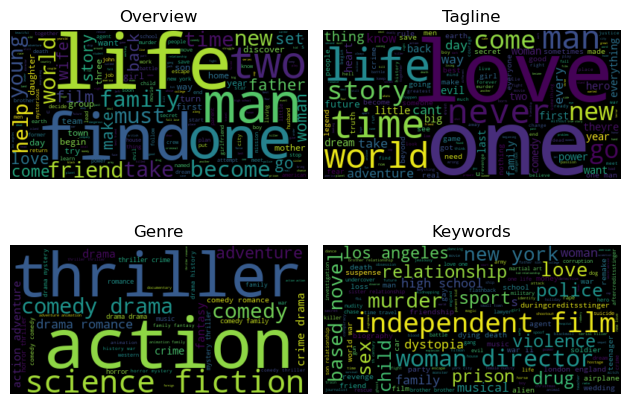

In [1098]:
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_overview, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_tagline, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_genre_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_keywords_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")


plt.tight_layout()
plt.show()

### Topic modelling

Topic modelling is performed using LDA. Topic modelling is implemented using [this](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) article.

In [1412]:
def getImportantWords(tf_idf, corpus, dictionary): #find 10 most important words based on TF-IDF
    important_words = []
    for d in range(0,len(corpus)):
        index_largest = tf_idf[d,:].argsort()[-10:]
        #important_words[d] = 
        important_words.append([dictionary[i] for i in index_largest])
        
    return important_words

In [1415]:
importantWords_overview = getImportantWords(TF_IDF_overview, overviewCorpus, overview_dict)
importantWords_tagline = getImportantWords(TF_IDF_tagline, taglineCorpus, tagline_dict)
importantWords_genre = getImportantWords(TF_IDF_genre, genreCorpus, genre_dict)
importantWords_keywords = getImportantWords(TF_IDF_keywords, keywordsCorpus, keywords_dict)

In [1417]:
#create corpus from important words
overviewCorpus_importantW =  [id2word.doc2bow(text) for text in importantWords_overview]
taglineCorpus_importantW =  [id2word.doc2bow(text) for text in importantWords_tagline]
genreCorpus_importantW =  [id2word.doc2bow(text) for text in importantWords_genre]
keywordsCorpus_importantW =  [id2word.doc2bow(text) for text in importantWords_keywords]

In [1418]:
def LDA(n_topics, corpus): #create function for LDA
    lda = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word=id2word,
                                       num_topics=n_topics)
    return lda

#### Number of topics
The number of topics is estimated using perplexity and coherence score. The estimation is performed using [this](https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920) article.

In [1242]:
def numberOfTopics(maxTopics, corpus, text, dictionary):
    perplexityScore = {}
    coherenceScore = {}
    nTopic = []
    for i in tqdm(range(1, maxTopics+1, 15)):
        lda = LDA(i, corpus)
        perplexityScore[i] = lda.log_perplexity(corpus)
        
        coherenceLDA = CoherenceModel(model = lda, texts = text, dictionary = dictionary, coherence = 'c_v') #coherence model
        LDAcoherenceScore = coherenceLDA.get_coherence() #coherence score
        coherenceScore[i] = LDAcoherenceScore
#        coherenceScore.append(LDAcoherenceScore)
        
    return perplexityScore, coherenceScore

In [1243]:
perplexity, coherence = numberOfTopics(150, overviewCorpus, overviewText, overview_dict)

#60%

 40%|█████████████████▌                          | 4/10 [01:31<02:16, 22.79s/it]


KeyError: 13603

In [1230]:
perplexity, coherence_cv, coherence_umass = numberOfTopics(50, overviewCorpus, overviewText, overview_dict)

100%|█████████████████████████████████████████████| 5/5 [01:41<00:00, 20.35s/it]


In [ ]:
#look at the topics, and choose the number with relevant ones

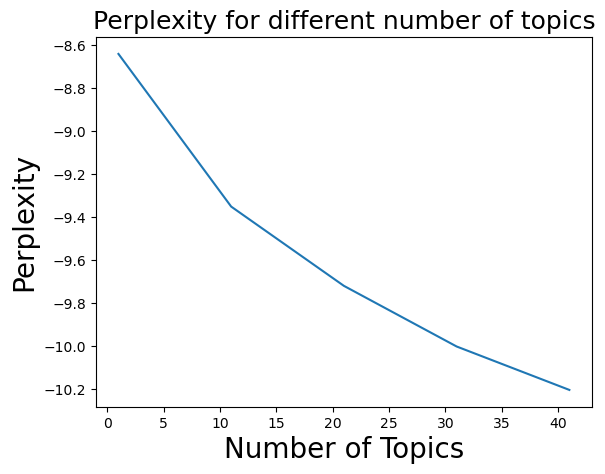

In [1231]:
#plot
plt.plot(perplexity.keys(), perplexity.values())
plt.xlabel('Number of Topics', fontsize=20)
plt.ylabel('Perplexity', fontsize=20)
plt.title('Perplexity for different number of topics', fontsize = 18)
plt.show()

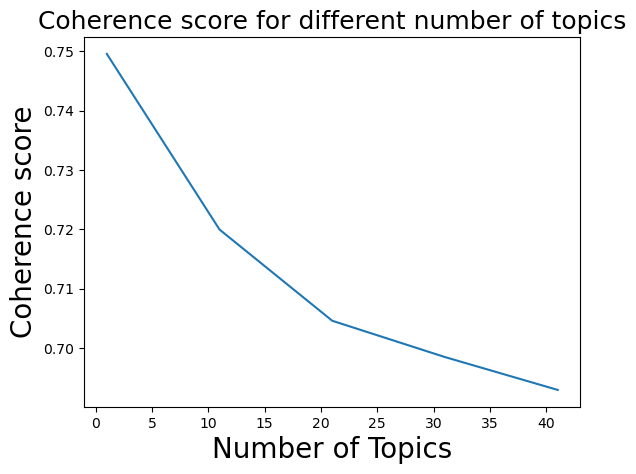

In [1234]:
#plot
plt.plot(coherence_cv.keys(), coherence_cv.values())
plt.xlabel('Number of Topics', fontsize=20)
plt.ylabel('Coherence score', fontsize=20)
plt.title('Coherence score for different number of topics', fontsize = 18)
plt.show()

In [1400]:
#create LDA
overviewLDA = LDA(200, overviewCorpus)
taglineLDA = LDA(20, taglineCorpus)
genreLDA = LDA(20, genreCorpus)
keywordsLDA = LDA(20, keywordsCorpus)

In [1455]:
#Create LDA for important words(from tf-idf)
overviewLDA_importantW = LDA(20, overviewCorpus_importantW )
taglineLDA_importantW = LDA(20, taglineCorpus_importantW )
genreLDA_importantW = LDA(20, genreCorpus_importantW )
keywordsLDA_importantW = LDA(20, keywordsCorpus_importantW )

# !!!NB.
Need to print some of the topics, to see if it makes sense to use TF-IDF or not. For genre it does not. Topic modelling show the genre, that is most "true" if there are several. 
We do also need to choose number of topics!!!!!
Choose topics, based on how many we want in same topic. 

In [1451]:
def assignTopic(lda, text, corpus): #assign topic with highest score
    assignedTopic = []
    for t in lda[corpus]: #loop through topics
        topic = []
        score = []
        for i in t:
            topic.append(i[0])
            score.append(i[1])
        assignedTopic.append(topic[np.argmax(score)]) #assign topic with highest score
    return assignedTopic

In [1434]:
#get columns for topics
overviewTopic = assignTopic(overviewLDA, overviewText, overviewCorpus)
taglineTopic = assignTopic(taglineLDA, taglineText, taglineCorpus)
genreTopic = assignTopic(genreLDA, genreText, genreCorpus)
keywordsTopic = assignTopic(keywordsLDA, keywordsText, keywordsCorpus)

In [1470]:
#get columns for topics for text from TF-IDF(10 most important words)
overviewTopic_importantW = assignTopic(overviewLDA_importantW, importantWords_overview, overviewCorpus_importantW)
taglineTopic_importantW = assignTopic(taglineLDA_importantW, importantWords_tagline, taglineCorpus_importantW)
genreTopic_importantW = assignTopic(genreLDA_importantW, importantWords_genre, genreCorpus_importantW)
keywordsTopic_importantW = assignTopic(keywordsLDA_importantW, importantWords_keywords, keywordsCorpus_importantW)

In [1472]:
columnNames =['Overview Topic', 'Tagline Topic', 'Genre Topic', 'Keywords Topic', 'Overview Important Topic', 'Tagline Important Topic', 'Genre Important Topic', 'Keywords Important Topic']

In [1490]:
df_topics = pd.DataFrame(data = (overviewTopic, taglineTopic, genreTopic, keywordsTopic, overviewTopic_importantW, taglineTopic_importantW, genreTopic_importantW , keywordsTopic_importantW)).T
df_topics.columns = columnNames

df_topics

Overview Topic  Tagline Topic  Genre Topic  Keywords Topic  \
0                 91              3           10              18   
1                138              0           14              18   
2                 39              7           14               1   
3                  6             18           14               1   
4                198             11           17              19   
...              ...            ...          ...             ...   
2055              89              0           17               5   
2056             193             13            4              15   
2057             124              0            7               0   
2058              34             10            7               6   
2059             100              4            7               5   

      Overview Important Topic  Tagline Important Topic  \
0                           12                        6   
1                            8                        1   
2                           13                        5   
3                           17                        3   
4                           11                       14   
...                        ...                      ...   
2055                        17                       15   
2056                         7                       17   
2057                        19                       15   
2058                        12                       11   
2059                         3                        3   

      Genre Important Topic  Keywords Important Topic  
0                        16                         5  
1                        14                        11  
2                        14                         8  
3                        14                        13  
4                        14                        18  
...                     ...                       ...  
2055                     14                        16  
2056                      9                         3  
2057                     14                        14  
2058                     14                         0  
2059                     14                         3  

[2060 rows x 8 columns]

In [ ]:
#add overviewTopic, taglineTopic, genreTopic and keywordTopic to df

In [1247]:
#choose high number, to have fewer movies in a topic. 
#Use TF-IDF, except for genre
#Check how many genres there are, and base topics on that

In [1248]:
# Print the Keyword in the 10 topics
pprint(overviewLDA.print_topics())

[(182,
  '0.014*"life" + 0.011*"charlie" + 0.011*"story" + 0.009*"rugrats" + '
  '0.008*"change" + 0.008*"love" + 0.008*"city" + 0.007*"two" + 0.007*"new" + '
  '0.006*"sister"'),
 (82,
  '0.010*"life" + 0.009*"father" + 0.008*"york" + 0.008*"new" + '
  '0.007*"musketeer" + 0.007*"bruce" + 0.006*"find" + 0.006*"world" + '
  '0.006*"love" + 0.005*"one"'),
 (61,
  '0.011*"rise" + 0.010*"lead" + 0.010*"rob" + 0.010*"future" + 0.010*"money" '
  '+ 0.010*"english" + 0.010*"local" + 0.006*"daughter" + 0.006*"ling" + '
  '0.006*"tony"'),
 (176,
  '0.012*"nicky" + 0.011*"buck" + 0.009*"end" + 0.009*"life" + 0.008*"jess" + '
  '0.008*"chuck" + 0.007*"become" + 0.006*"past" + 0.006*"lip" + '
  '0.006*"harker"'),
 (169,
  '0.012*"woman" + 0.011*"two" + 0.010*"sidney" + 0.008*"billy" + '
  '0.008*"trail" + 0.008*"time" + 0.007*"doug" + 0.007*"life" + '
  '0.007*"college" + 0.007*"money"'),
 (139,
  '0.011*"school" + 0.010*"neighborhood" + 0.009*"one" + 0.009*"mr" + '
  '0.008*"track" + 0.007*"life

In [1249]:
def LDA_plot(path, lda_model, corpus):
    #Visualize topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join(path + str(num_topics))
    
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
            
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
        
    pyLDAvis.save_html(LDAvis_prepared, path+ str(num_topics) +'.html')
    
    return LDAvis_prepared 

In [1496]:
overviewLDA_plot = LDA_plot('results/ldavis_prepared_', overviewLDA, overviewCorpus)
taglineLDA_plot = LDA_plot('results/ldavis_prepared_', taglineLDA, taglineCorpus)
genreLDA_plot = LDA_plot('results/ldavis_prepared_', genreLDA, genreCorpus)
keywordsLDA_plot = LDA_plot('results/ldavis_prepared_', keywordsLDA, keywordsCorpus)

In [1497]:
overviewLDA_plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
65    -0.110910  0.000751       1        1  1.221982
6     -0.122227 -0.041596       2        1  1.173072
43    -0.092953  0.028356       3        1  1.045110
113   -0.072583  0.039342       4        1  0.978230
23    -0.113627 -0.018263       5        1  0.972730
...         ...       ...     ...      ...       ...
28     0.096552 -0.007332     196        1  0.172803
183    0.115851  0.030748     197        1  0.138851
173    0.170683 -0.022881     198        1  0.131623
91     0.155869  0.036045     199        1  0.092621
49     0.159073  0.003995     200        1  0.074750

[200 rows x 5 columns], topic_info=        Term        Freq       Total  Category  logprob  loglift
146     life  340.000000  340.000000   Default  30.0000  30.0000
133    story  137.000000  137.000000   Default  29.0000  29.0000
84       man  178.000000  178.000000   Default  28.0000  28.0000
498     love  163.000000  163.000000   Default  27.0000  27.0000
599      get  189.000000  189.000000   Default  26.0000  26.0000
...      ...         ...         ...       ...      ...      ...
1637  search    0.378447   29.496005  Topic200  -4.7674   2.8428
1521  forced    0.378650   39.795406  Topic200  -4.7668   2.5439
2074    know    0.378281   50.253620  Topic200  -4.7678   2.3096
86    family    0.378392  161.514225  Topic200  -4.7675   1.1424
525     home    0.271631   81.538132  Topic200  -5.0990   1.4944

[11906 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
11632     23  0.355903         &
9119      43  0.544716         /
10741     82  0.543519       aaa
3513      67  0.596251     aames
5050      97  0.574941  abagnale
...      ...       ...       ...
448       28  0.151316         …
448       64  0.151316         …
448       75  0.151316         …
448      137  0.151316         …
448      180  0.151316         …

[32312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[66, 7, 44, 114, 24, 155, 164, 142, 90, 13, 82, 98, 124, 16, 167, 10, 84, 17, 188, 2, 138, 63, 190, 4, 186, 76, 133, 46, 70, 112, 74, 61, 40, 3, 45, 59, 113, 105, 146, 110, 101, 42, 158, 166, 159, 100, 172, 152, 141, 94, 60, 197, 178, 52, 19, 191, 163, 147, 139, 55, 195, 32, 151, 187, 99, 194, 183, 111, 64, 125, 200, 119, 156, 132, 93, 171, 120, 41, 71, 192, 25, 68, 150, 12, 177, 162, 145, 88, 107, 28, 23, 11, 69, 199, 193, 108, 14, 15, 26, 136, 161, 131, 37, 97, 87, 198, 95, 34, 181, 189, 75, 165, 143, 106, 137, 179, 126, 38, 78, 65, 51, 89, 135, 20, 5, 53, 169, 103, 168, 104, 116, 77, 18, 39, 31, 86, 130, 123, 49, 128, 27, 109, 30, 35, 102, 175, 115, 72, 79, 148, 80, 127, 85, 6, 62, 67, 140, 173, 22, 160, 1, 43, 185, 57, 54, 134, 36, 170, 154, 196, 8, 176, 81, 91, 73, 149, 157, 47, 118, 117, 96, 9, 33, 153, 83, 121, 122, 180, 56, 129, 48, 58, 144, 21, 182, 29, 184, 174, 92, 50])

In [730]:
#Visualize topics
pyLDAvis.enable_notebook()
overviewLDA_path = os.path.join('./results/lda_overview_'+str(num_topics))

if 1 == 1:
    overviewLDA_prepared = pyLDAvis.gensim.prepare(overviewLDA, overviewCorpus, id2word)
    with open(overviewLDA_path, 'wb') as f:
        pickle.dump(overviewLDA_prepared , f)
        
with open(overviewLDA_path, 'rb') as f:
    overviewLDA_prepared = pickle.load(f)
pyLDAvis.save_html(overviewLDA_prepared, './results/lda_overview_'+ str(num_topics) +'.html')
overviewLDA_prepared

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
#m

In [417]:
#do this in dict

In [425]:
#overviewText[0]
overviewText[0].count("kingdom")

1

In [444]:
doc_count = 0
for i in overviewText:
    doc_count += 1
    count = i.count('kingdom')
    #print(count)
    print(i, count)

['kingdom', 'wantedand', 'charmingbandit', 'flynn', 'rider', 'hide', 'mysterious', 'tower', 'taken', 'hostage', 'rapunzel', 'beautiful', 'feisty', 'towerbound', 'teen', 'foot', 'magical', 'golden', 'hair', 'flynns', 'curious', 'captor', 'looking', 'ticket', 'tower', 'locked', 'away', 'year', 'strike', 'deal', 'handsome', 'thief', 'unlikely', 'duo', 'set', 'actionpacked', 'escapade', 'complete', 'supercop', 'horse', 'overprotective', 'chameleon', 'gruff', 'gang', 'pub', 'thug']
['kingdom', 'wantedand', 'charmingbandit', 'flynn', 'rider', 'hide', 'mysterious', 'tower', 'taken', 'hostage', 'rapunzel', 'beautiful', 'feisty', 'towerbound', 'teen', 'foot', 'magical', 'golden', 'hair', 'flynns', 'curious', 'captor', 'looking', 'ticket', 'tower', 'locked', 'away', 'year', 'strike', 'deal', 'handsome', 'thief', 'unlikely', 'duo', 'set', 'actionpacked', 'escapade', 'complete', 'supercop', 'horse', 'overprotective', 'chameleon', 'gruff', 'gang', 'pub', 'thug'] 1
['unexpected', 'enemy', 'emerges',

In [428]:
#def countWords(dictionary, corpus):
#    for 
#    wordCount = {}
#    docCount
#    for key in dictionary:
#        word = dictionary[key]
#        for i in corpus:
#            count = i.count(word)
#        wordCount
            
#save dict
#key: document, {word: count} 

In [504]:
#doc_count = 0
#countDict = {}
#for i in overviewText:
#    doc_count += 1
#    wordCount = {}
#    for key in overview_dict:
#        word = overview_dict[key]
#        count = i.count(word)
#        wordCount[overview_dict[key]] = count
#    countDict['Doc'+str(doc_count)] = wordCount
        #count = i.count(overview_dict[key])

In [502]:
def countWords(corpus):
    docCount = 0
    countDict = {}
    for words in corpus:
        docCount += 1
        wordCount = {}
        for w in words:
            w_count = words.count(w)
            wordCount[w] = w_count
        countDict['Doc'+ str(docCount)] = wordCount
    return countDict

In [503]:
countWords(overviewText)

{'Doc1': {'kingdom': 1,
  'wantedand': 1,
  'charmingbandit': 1,
  'flynn': 1,
  'rider': 1,
  'hide': 1,
  'mysterious': 1,
  'tower': 2,
  'taken': 1,
  'hostage': 1,
  'rapunzel': 1,
  'beautiful': 1,
  'feisty': 1,
  'towerbound': 1,
  'teen': 1,
  'foot': 1,
  'magical': 1,
  'golden': 1,
  'hair': 1,
  'flynns': 1,
  'curious': 1,
  'captor': 1,
  'looking': 1,
  'ticket': 1,
  'locked': 1,
  'away': 1,
  'year': 1,
  'strike': 1,
  'deal': 1,
  'handsome': 1,
  'thief': 1,
  'unlikely': 1,
  'duo': 1,
  'set': 1,
  'actionpacked': 1,
  'escapade': 1,
  'complete': 1,
  'supercop': 1,
  'horse': 1,
  'overprotective': 1,
  'chameleon': 1,
  'gruff': 1,
  'gang': 1,
  'pub': 1,
  'thug': 1},
 'Doc2': {'unexpected': 1,
  'enemy': 1,
  'emerges': 1,
  'threatens': 1,
  'global': 1,
  'safety': 1,
  'security': 1,
  'nick': 1,
  'fury': 1,
  'director': 1,
  'international': 1,
  'peacekeeping': 1,
  'agency': 1,
  'known': 1,
  'shield': 1,
  'find': 1,
  'need': 1,
  'team': 1,
  '

In [607]:
overviewText

[['kingdom',
  'wantedand',
  'charmingbandit',
  'flynn',
  'rider',
  'hide',
  'mysterious',
  'tower',
  'taken',
  'hostage',
  'rapunzel',
  'beautiful',
  'feisty',
  'towerbound',
  'teen',
  'foot',
  'magical',
  'golden',
  'hair',
  'flynns',
  'curious',
  'captor',
  'looking',
  'ticket',
  'tower',
  'locked',
  'away',
  'year',
  'strike',
  'deal',
  'handsome',
  'thief',
  'unlikely',
  'duo',
  'set',
  'actionpacked',
  'escapade',
  'complete',
  'supercop',
  'horse',
  'overprotective',
  'chameleon',
  'gruff',
  'gang',
  'pub',
  'thug'],
 ['unexpected',
  'enemy',
  'emerges',
  'threatens',
  'global',
  'safety',
  'security',
  'nick',
  'fury',
  'director',
  'international',
  'peacekeeping',
  'agency',
  'known',
  'shield',
  'find',
  'need',
  'team',
  'pull',
  'world',
  'back',
  'brink',
  'disaster',
  'spanning',
  'globe',
  'daring',
  'recruitment',
  'effort',
  'begin'],
 ['soldier',
  'robin',
  'happens',
  'upon',
  'dying',
  'ro

In [612]:
def tf(corpus): #call TF with word and document
    doc_dict = countWords(corpus)
    for key in doc_dict.keys(): #loop through corpus(documents)
        f = np.array(list(doc_dict[key].values())) #array of occurences in document d
        TF = f/max(f) #array of term frequency of document d
        
    return TF

In [712]:
def tf(word, doc):
    print(doc)

In [711]:
#make one function, that calculate tf for each word and each document
#make one function, that calculate idf for each word and each document, where it is called by the word and doc number

[['kingdom',
  'wantedand',
  'charmingbandit',
  'flynn',
  'rider',
  'hide',
  'mysterious',
  'tower',
  'taken',
  'hostage',
  'rapunzel',
  'beautiful',
  'feisty',
  'towerbound',
  'teen',
  'foot',
  'magical',
  'golden',
  'hair',
  'flynns',
  'curious',
  'captor',
  'looking',
  'ticket',
  'tower',
  'locked',
  'away',
  'year',
  'strike',
  'deal',
  'handsome',
  'thief',
  'unlikely',
  'duo',
  'set',
  'actionpacked',
  'escapade',
  'complete',
  'supercop',
  'horse',
  'overprotective',
  'chameleon',
  'gruff',
  'gang',
  'pub',
  'thug'],
 ['unexpected',
  'enemy',
  'emerges',
  'threatens',
  'global',
  'safety',
  'security',
  'nick',
  'fury',
  'director',
  'international',
  'peacekeeping',
  'agency',
  'known',
  'shield',
  'find',
  'need',
  'team',
  'pull',
  'world',
  'back',
  'brink',
  'disaster',
  'spanning',
  'globe',
  'daring',
  'recruitment',
  'effort',
  'begin'],
 ['soldier',
  'robin',
  'happens',
  'upon',
  'dying',
  'ro

In [713]:
def tfIDF(corpus, dictionary):
    N = len(corpus) #number of documents
    #for key in doc_dict.keys(): #loop through corpus(documents)
        #f = np.array(list(doc_dict[key].values())) #array of occurences in document d
        #TF = f/max(f) #array of term frequency of document d
        #print(TF)
       # count = 0
        
        #find all words appearing 
        #loop through dictionary,
    docDict = countWords(corpus) #dict with count of words in each doc 
    for w in dictionary: #loop through all words in dictionary
        word = dictionary[w]
        n_w = 0 #number of document word w appears in
        for doc in docDict: #loop through docs
            words = docDict[doc].keys()
            if word in words: 
                n_w += 1 #
        IDF = math.log2(N/n_w) #IDF for word w
        
        TF = tf(word, doc)
        #d = tf * IDF #for word w in document d
#        print(word, n_w)
        #print(word, IDF)
            
            
        
        #for word in doc_dict[key].keys(): #loop through the words in each corpus
        #    if word in doc_dict[key]:
        #        count += 1
#        print(1, list(doc_dict[key].keys()))
        #n_w = #number documents word w appears in
        
    #f = countWords(corpus).values()
    #frequency of word w in document d
    #TF = f/max(f) #max(f) is the max of occurences in document d
#    return 

In [714]:

import math


#remove ;

In [715]:
tfIDF(overviewText, overview_dict)

Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060
Doc2060


In [554]:
np.array(list(countWords(overviewText)['Doc1'].values()))/2

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [ ]:
import numpy
myArray = numpy.array([10,20,30,40,50,60,70,80,90])
myInt = 10
newArray = myArray/myInt

In [339]:
len(overviewText)

2060

In [340]:
df_preprocessed

overview  \
0     kingdom wanted-and charming-bandit flynn rider...   
1     unexpected enemy emerges threatens global safe...   
2     soldier robin happens upon dying robert loxley...   
3     1933 new york overly ambitious movie producer ...   
4     84 year later 101-year-old woman named rose de...   
...                                                 ...   
2055  present day life austin texas among social out...   
2056  notorious baltimore criminal underground figur...   
2057  various woman struggle function oppressively s...   
2058  wave gruesome murder sweeping tokyo connection...   
2059  friends/fledgling entrepreneur invent device g...   

                                 tagline                        genre_text  \
0     theyre taking adventure new length                  animation family   
1                      assembly required  science fiction action adventure   
2             rise rise lamb become lion                  action adventure   
3                    eighth wonder world            adventure drama action   
4               nothing earth could come            drama romance thriller   
...                                  ...                               ...   
2055                                                                comedy   
2056                 exercise poor taste               horror comedy crime   
2057                                                         drama foreign   
2058               madness terror murder     crime horror mystery thriller   
2059               happens actually work    science fiction drama thriller   

                                          keywords_text  
0     hostage magic horse fairy tale musical princes...  
1     new york shield marvel comic superhero based c...  
2     robin hood archer knight sherwood forest bow a...  
3     film business screenplay show business film ma...  
4     shipwreck iceberg ship panic titanic ocean lin...  
...                                                 ...  
2055  moon philosophy burglar texas dream atomic bom...  
2056  gay trailer park pop culture drug dealer heroi...  
2057                                                     
2058  japan prostitute hotel based novel hallucinati...  
2059  distrust garage identity crisis time travel ti...  

[2060 rows x 4 columns]

In [ ]:
#calculate tf-idf for each word in each of the dictionaries

In [337]:
print(overview_dict[70])

#print(corpus[:1][0][:30])

spanning


In [309]:
[overview_dict.doc2bow(t) for t in overview_dict]

TypeError: 'int' object is not iterable

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [228]:
textSplit_array = np.array(text_split)

corpora.Dictionary(textSplit_array)

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [219]:
text.split()

['kingdom',
 'wanted-and',
 'charming-bandit',
 'flynn',
 'rider',
 'hide',
 'mysterious',
 'tower',
 'taken',
 'hostage',
 'rapunzel',
 'beautiful',
 'feisty',
 'tower-bound',
 'teen',
 '70',
 'foot',
 'magical',
 'golden',
 'hair',
 'flynns',
 'curious',
 'captor',
 'looking',
 'ticket',
 'tower',
 'locked',
 'away',
 'year',
 'strike',
 'deal',
 'handsome',
 'thief',
 'unlikely',
 'duo',
 'set',
 'action-packed',
 'escapade',
 'complete',
 'super-cop',
 'horse',
 'over-protective',
 'chameleon',
 'gruff',
 'gang',
 'pub',
 'thug',
 'unexpected',
 'enemy',
 'emerges',
 'threatens',
 'global',
 'safety',
 'security',
 'nick',
 'fury',
 'director',
 'international',
 'peacekeeping',
 'agency',
 'known',
 'shield',
 'find',
 'need',
 'team',
 'pull',
 'world',
 'back',
 'brink',
 'disaster',
 'spanning',
 'globe',
 'daring',
 'recruitment',
 'effort',
 'begin',
 'soldier',
 'robin',
 'happens',
 'upon',
 'dying',
 'robert',
 'loxley',
 'promise',
 'return',
 'man',
 'sword',
 'family',


In [227]:
texts = text.split()
id2word  = corpora.Dictionary([[word] for word in texts]) #create dictionary
corpus = [id2word.doc2bow(texts) for text in texts] #create corpus



KeyboardInterrupt: 

In [ ]:
corpus

In [206]:
import gensim.corpora as corpora
# Create Dictionary
text = ' '.join(df_preprocessed.overview)
text_split = text.split()
id2word = corpora.Dictionary(text_split)
id2word
# Create Corpus
#texts = data_words
# Term Document Frequency
#corpus = [id2word.doc2bow(text) for text in texts]
# View
#print(corpus[:1][0][:30])

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
#tf-idf

In [ ]:
wordCloud(df_preprocessed, 'tagline')

In [ ]:
#instead of colText, call wordcloud(function) for a column, which call colText of that column

In [114]:
#join text in list for the column
df_preprocessed.columns

Index(['overview', 'tagline', 'genre_text', 'keywords_text'], dtype='object')

In [87]:
text1 = df_preprocessed['overview'].iloc[0]

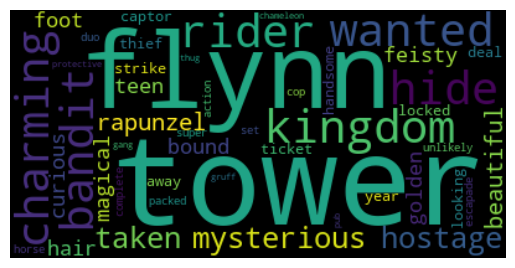

In [88]:
wordcloud = WordCloud().generate(text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
from wordcloud import WordCloud
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [56]:
text = df.description[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"When the kingdom's most wanted-and most charming-bandit Flynn Rider hides out in a mysterious tower, he's taken hostage by Rapunzel, a beautiful and feisty tower-bound teen with 70 feet of magical, golden hair. Flynn's curious captor, who's looking for her ticket out of the tower where she's been locked away for years, strikes a deal with the handsome thief and the unlikely duo sets off on an action-packed escapade, complete with a super-cop horse, an over-protective chameleon and a gruff gang of pub thugs."

In [63]:
df_tmdb

budget                                             genres  \
6     260000000  [{"id": 16, "name": "Animation"}, {"id": 10751...   
16    220000000  [{"id": 878, "name": "Science Fiction"}, {"id"...   
21    200000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
24    207000000  [{"id": 12, "name": "Adventure"}, {"id": 18, "...   
25    200000000  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
...         ...                                                ...   
4779          0                     [{"id": 35, "name": "Comedy"}]   
4788      12000  [{"id": 27, "name": "Horror"}, {"id": 35, "nam...   
4790          0  [{"id": 18, "name": "Drama"}, {"id": 10769, "n...   
4792      20000  [{"id": 80, "name": "Crime"}, {"id": 27, "name...   
4796       7000  [{"id": 878, "name": "Science Fiction"}, {"id"...   

                                          homepage     id  \
6     http://disney.go.com/disneypictures/tangled/  38757   
16               http://marvel.com/avengers_movie/  24428   
21               http://www.robinhoodthemovie.com/  20662   
24                                             NaN    254   
25                     http://www.titanicmovie.com    597   
...                                            ...    ...   
4779                                           NaN  14022   
4788                                           NaN    692   
4790                                           NaN  13898   
4792                                           NaN  36095   
4796                    http://www.primermovie.com  14337   

                                               keywords original_language  \
6     [{"id": 1562, "name": "hostage"}, {"id": 2343,...                en   
16    [{"id": 242, "name": "new york"}, {"id": 5539,...                en   
21    [{"id": 4147, "name": "robin hood"}, {"id": 43...                en   
24    [{"id": 774, "name": "film business"}, {"id": ...                en   
25    [{"id": 2580, "name": "shipwreck"}, {"id": 298...                en   
...                                                 ...               ...   
4779  [{"id": 305, "name": "moon"}, {"id": 490, "nam...                en   
4788  [{"id": 237, "name": "gay"}, {"id": 900, "name...                en   
4790                                                 []                fa   
4792  [{"id": 233, "name": "japan"}, {"id": 549, "na...                ja   
4796  [{"id": 1448, "name": "distrust"}, {"id": 2101...                en   

      original_title                                           overview  \
6            Tangled  When the kingdom's most wanted-and most charmi...   
16      The Avengers  When an unexpected enemy emerges and threatens...   
21        Robin Hood  When soldier Robin happens upon the dying Robe...   
24         King Kong  In 1933 New York, an overly ambitious movie pr...   
25           Titanic  84 years later, a 101-year-old woman named Ros...   
...              ...                                                ...   
4779         Slacker  Presents a day in the life in Austin, Texas am...   
4788  Pink Flamingos  Notorious Baltimore criminal and underground f...   
4790           دایره  Various women struggle to function in the oppr...   
4792             キュア  A wave of gruesome murders is sweeping Tokyo. ...   
4796          Primer  Friends/fledgling entrepreneurs invent a devic...   

      popularity                               production_companies  ...  \
6      48.681969  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...   
16    144.448633  [{"name": "Paramount Pictures", "id": 4}, {"na...  ...   
21     37.668301  [{"name": "Imagine Entertainment", "id": 23}, ...  ...   
24     61.226010  [{"name": "WingNut Films", "id": 11}, {"name":...  ...   
25    100.025899  [{"name": "Paramount Pictures", "id": 4}, {"na...  ...   
...          ...                                                ...  ...   
4779    3.320622                                                 []  ...   
4

Movie_ID  Year                    Name
2             3  1997               Character
23           24  1981     My Bloody Valentine
29           30  2003  Something's Gotta Give
44           45  1999         The Love Letter
54           55  1995                    Jade
...         ...   ...                     ...
17742     17743  2003    Better Luck Tomorrow
17757     17758  1979                Prophecy
17761     17762  1997                 Gattaca
17763     17764  1998     Shakespeare in Love
17768     17769  2003             The Company

[2244 rows x 3 columns]

In [9]:
df_ratings = ratings[ratings.Movie_ID.isin(df_movies.Movie_ID)]
df_ratings

User_ID  Rating  Movie_ID
0          712664       5         3
1         1331154       4         3
2         2632461       3         3
3           44937       5         3
4          656399       4         3
...           ...     ...       ...
17324875    15737       2      4492
17324876   502274       2      4492
17324877  1326640       3      4492
17324878   633738       3      4492
17324879  1065921       2      4492

[10023858 rows x 3 columns]

# Topic modelling

### Initial EDA analysis as a foundation for the methods in W5 (Apripro/FP-Growth for frequent item-set mining)

Basic statistics: mean, median, and standard deviation

For df_rating: Finding out these values for the Rating column.

For df_movies: Finding out thhe distribution of movies across years. This will to contexualise the ratings to help understand viewer taste and perhaps how rating behaviour changes over time/movie release time.

In [9]:
# For df_ratings
mean_ratings = df_ratings['Rating'].mean()
median_rating = df_ratings['Rating'].median()
std_rating = df_ratings['Rating'].std()

# For df_movies
mean_year = df_movies['Year'].mean()
median_year = df_movies['Year'].median()
std_year = df_movies['Year'].std()

Visualisations:
- Using a histogram for the Rating column of df_ratings to see the frequency of each rating.
- Using a histogram on the year column of df_movies to see the number of movies released year year, only including the movies that have been rated.
- Using scatter plots to visualise the relationships between release year and average rating, as an example.

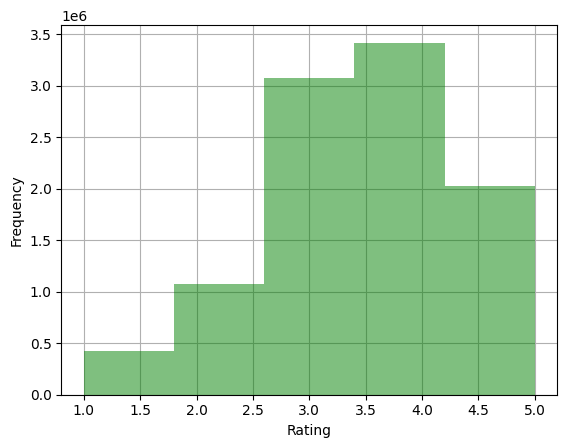

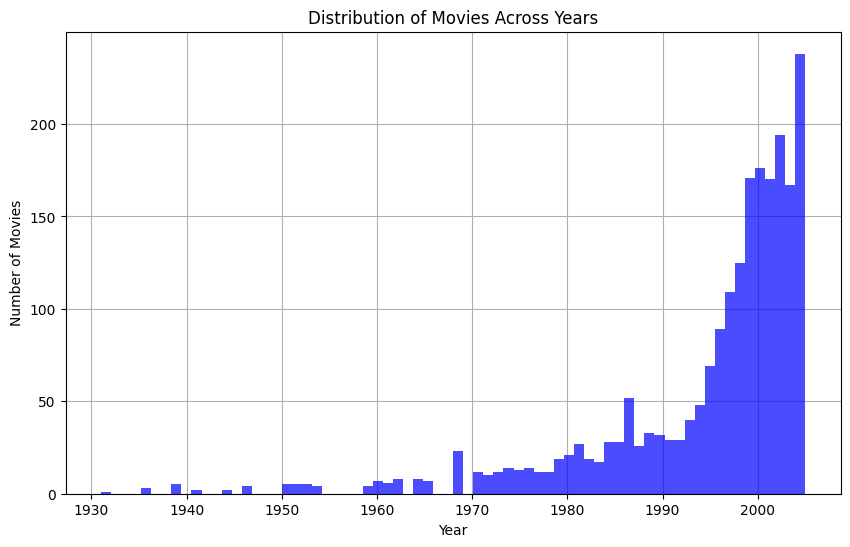

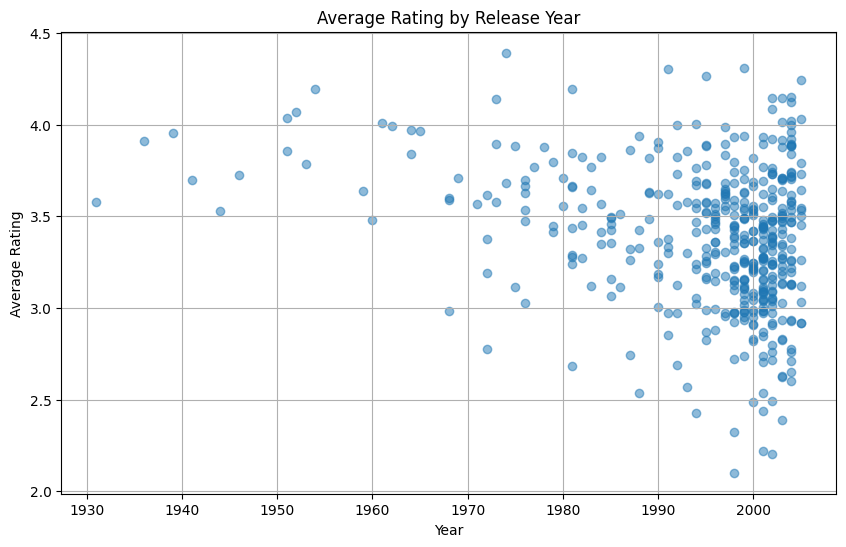

In [10]:
# Merge the dataframes on 'Movie_ID'
df_merged = pd.merge(df_movies, df_ratings, on='Movie_ID')
# Find unique years with ratings
unique_years_with_ratings = df_merged['Year'].unique()
# Filter df_movies using the unique years
df_movies_filtered = df_movies[df_movies['Year'].isin(unique_years_with_ratings)]

# Histogram for Ratings using df_ratings_filtered
plt.hist(df_ratings['Rating'], bins=5, alpha=0.5, color='g', zorder=2)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True, zorder=1)
plt.show()

# Histogram for Year using df_movies_filtered
plt.figure(figsize=(10, 6))
plt.hist(df_movies_filtered['Year'], bins=70, alpha=0.7, color='b', zorder=2)
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies Across Years')
plt.grid(True, zorder=1)
plt.show()

# Calculate Average Ratings for Scatter Plot
df_avg_ratings = df_merged.groupby(['Movie_ID', 'Year'])['Rating'].mean().reset_index()

# Scatter Plot for Average Rating by Release Year
plt.figure(figsize=(10, 6))
plt.scatter(df_avg_ratings['Year'], df_avg_ratings['Rating'], alpha=0.5)
plt.title('Average Rating by Release Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

### Initial data transformation and graph analysis as a foundation for methods in W7 (Mining Social-Network Graphs/Betweeness Centrality)

Add weighted edge based on the number of common raters

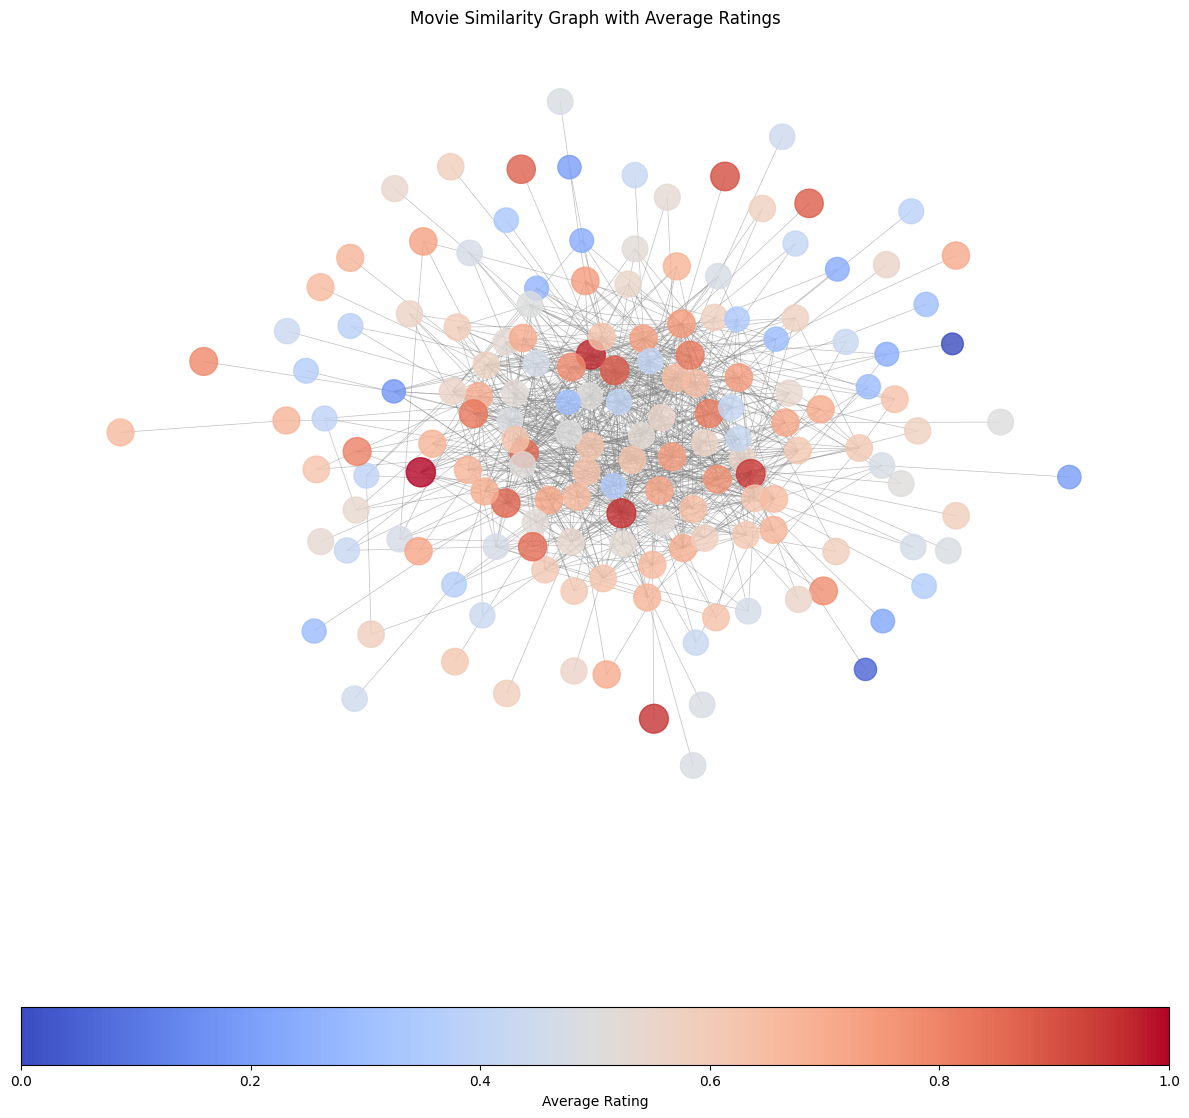

                                          Movie Names  Degree
0   Pirates of the Caribbean: The Curse of the Bla...      55
1                                     The Sixth Sense      50
2                                      Bruce Almighty      46
3                                             Shrek 2      45
4                                     American Beauty      42
5                                      50 First Dates      41
6                                          Braveheart      37
7                                The Bourne Supremacy      37
8                                   Kill Bill: Vol. 2      35
9                                    The Last Samurai      35
10                                              Ghost      34
11                                  Road to Perdition      32
12                                    Men in Black II      32
13                                The Wedding Planner      31
14                                              Speed      31
15      

In [11]:
# Sample a smaller fraction for faster processing
df_ratings_sample = df_ratings.sample(frac=0.01)

user_movies_dict = df_ratings_sample.groupby('User_ID')['Movie_ID'].apply(set).to_dict()

edges_to_add = Counter()
for movies in user_movies_dict.values():
    edges_to_add.update(combinations(movies, 2))

# Create an empty graph
G = nx.Graph()

threshold = 5
G.add_edges_from((movie1, movie2, {'weight': weight}) for (movie1, movie2), weight in edges_to_add.items() if weight >= threshold)

# Compute average ratings for each movie
avg_ratings = df_ratings_sample.groupby('Movie_ID')['Rating'].mean().to_dict()

# Map node sizes based on ratings, with a scaling factor for visibility
node_sizes = [avg_ratings.get(movie, 0) * 100 for movie in G.nodes()]

# Movie titles, assuming df_movies DataFrame exists
movie_titles = df_movies.set_index('Movie_ID')['Name'].to_dict()

# Identify the top 20 movies by degree (connectivity)
top_20_degree_movies = sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:20]
top_20_movie_ids = [movie[0] for movie in top_20_degree_movies]

# Use a faster layout with fewer iterations
layout = nx.kamada_kawai_layout(G)

# Node colors based on average ratings
node_colors = [avg_ratings.get(movie, 0) for movie in G.nodes()]
cmap = plt.cm.coolwarm

weights = [G[u][v]['weight'] for u, v in G.edges()]

fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(G, layout, node_size=node_sizes, node_color=node_colors, cmap=cmap, alpha=0.8, ax=ax)
nx.draw_networkx_edges(G, layout, width=0.5, edge_color='grey', alpha=0.5, ax=ax)

ax.set_title("Movie Similarity Graph with Average Ratings")
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label='Average Rating', orientation='horizontal', ax=ax)
ax.axis('off')
plt.tight_layout()
plt.show()

# Create and display a table showcasing top 20 movies by degree
top_20_movie_names = [movie_titles[movie] for movie in top_20_movie_ids]
degree_values = [degree for _, degree in top_20_degree_movies]
data = {"Movie Names": top_20_movie_names, "Degree": degree_values}
df_top_20 = pd.DataFrame(data)

print(df_top_20)